In [22]:
import xarray as xa
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from matplotlib import colors
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib as mpl
import cartopy

In [19]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)
data = xa.open_dataarray('/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip')
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

In [9]:
slp_anomaly = xa.open_dataarray('../Composites/daily_slp_stand_anomaly.nc')
z500_anomaly = xa.open_dataarray('../Composites/daily_z500_stand_anomaly.nc')
ivt_a_anomaly = xa.open_dataarray('../Composites/daily_ivt_a_stand_anomaly.nc')
ivt_b_anomaly = xa.open_dataarray('../Composites/daily_ivt_b_stand_anomaly.nc')
tcwv_anomaly = xa.open_dataarray('../Composites/daily_tcwv_stand_anomaly.nc')
pv200_anomaly = xa.open_dataarray('../Composites/daily_pv200_stand_anomaly.nc')
q850_anomaly = xa.open_dataarray('../Composites/daily_q850_stand_anomaly.nc')

w500_anomaly = xa.open_dataarray('../Composites/daily_w500_std_anomaly.nc')
cape_anomaly = xa.open_dataarray('../Composites/daily_cape_std_anomaly.nc')

# Sub7

In [2]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')

In [3]:
print(np.where((tutt_sub>0)&(tc_sub>0)))

(array([ 173,  368,  457,  622,  623,  679, 1147, 1213, 1361, 1488, 1670,
       1870, 1871, 1872, 1873, 2066, 2229, 2256, 2287, 2587, 2719, 2720,
       2733, 3002]),)


In [7]:
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]
tc_tutt_days = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])
tc_tutt_days.time.data

array(['1981-07-09T00:00:00.000000000', '1983-09-04T00:00:00.000000000',
       '1984-08-18T00:00:00.000000000', '1986-08-17T00:00:00.000000000',
       '1986-08-18T00:00:00.000000000', '1987-07-26T00:00:00.000000000',
       '1993-08-22T00:00:00.000000000', '1994-08-13T00:00:00.000000000',
       '1996-08-24T00:00:00.000000000', '1998-07-19T00:00:00.000000000',
       '2000-09-17T00:00:00.000000000', '2003-08-23T00:00:00.000000000',
       '2003-08-24T00:00:00.000000000', '2003-08-25T00:00:00.000000000',
       '2003-08-26T00:00:00.000000000', '2006-07-26T00:00:00.000000000',
       '2008-07-25T00:00:00.000000000', '2008-08-24T00:00:00.000000000',
       '2009-06-24T00:00:00.000000000', '2013-07-09T00:00:00.000000000',
       '2014-09-14T00:00:00.000000000', '2014-09-15T00:00:00.000000000',
       '2015-06-18T00:00:00.000000000', '2018-08-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [8]:
tc_tutt_days = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])

In [15]:
from tqdm import tqdm
def distance_criteria(xs, ys, lons, lats):  # return distance.
    dis = 12345
    for x, y in zip(xs, ys):
        if x > 180: x = x - 360
        for lon, lat in zip(lons, lats):
            if lon > 180: lon = lon - 360
            distance = np.sqrt(np.square(x - lon) + np.square(y - lat))
            if distance <= 5:
                return True
            if dis > distance:
                dis = distance
    return dis
def start_end_time(sub_id):  # for all precipitation events.
    start = []
    end = []
    ext_times = precip_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        start.append(ext_times[i] - np.timedelta64(12, 'h'))
        end.append(ext_times[i] + np.timedelta64(12, 'h'))  # 12Z to 12Z
        i += 1
    return start, end
precip_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    precip_time = precip.where(precip > 1, drop=True).time.data
    print(len(precip_time))
    precip_days[sub_id] = precip_time

def TC_precip_loc(sub_id, sub_lons, sub_lats):
    tc_lats = []
    tc_lons = []
    start, end = start_end_time(sub_id)
    tc_induced_flag = np.zeros(len(start))
    ind_tc = 0
    for ind, (time1, time2) in enumerate(tqdm(zip(start, end))):  # time is 12Z.
        total_flag = 0
        start_time = time1
        end_time = time2
        # print(start_time, end_time)
        for i in range(np.maximum(ind_tc-5, 0), num_TCs):
            ind_tc = i
            tc = tc_record.isel(storm=i)
            tc_time = tc.time.dropna(dim='date_time').data
            tc_start = tc_time[0]
            tc_end = tc_time[-1]
            if tc_start > end_time:
                break
            if tc_end < start_time:
                continue
            common_start = np.max([start_time, tc_start])
            common_end = np.min([end_time, tc_end])
            diffstart = (tc_time - common_start) / np.timedelta64(1, 'h')
            diffend = (tc_time - common_end) / np.timedelta64(1, 'h')
            # keep the positive and find the min
            start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()
            # keep the negative and find the max.
            end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()
            tc_lat = tc.lat.isel(date_time=slice(start_ind, end_ind + 1)).data
            tc_lon = tc.lon.isel(date_time=slice(start_ind, end_ind + 1)).data
            dis_flag = distance_criteria(
                xs=tc_lon, ys=tc_lat, lons=sub_lons, lats=sub_lats)
            if dis_flag == True:
                # check type
                tc_type = set(tc.usa_status.isel(date_time=slice(start_ind, end_ind+1)).data)
                if tc_type.intersection(set([b'TS', b'TY', b'ST', b'TC', b'HU', b'HR']))==set():
                    pass
                else:
                    total_flag += 1
                    ave_lat = np.mean(tc_lat)
                    ave_lon = np.mean(tc_lon)
                    tc_lats.append(ave_lat)
                    tc_lons.append(ave_lon)
        if total_flag > 0:
            tc_induced_flag[ind] = 1
            # print('TC')
    return tc_induced_flag, tc_lats, tc_lons

sub_id:  1
767
sub_id:  2
761
sub_id:  3
728
sub_id:  4
1531
sub_id:  5
2353
sub_id:  6
2466
sub_id:  7
3048


In [16]:
tc_record = xa.open_dataset('/tempest/duan0000/exprecip/ERA5/sub_IBTrack.nc')
num_TCs = len(tc_record.storm)
print('NUM_TCs: ', num_TCs)

lons_sub = np.load('../ERA5/Calculations/' + str(7) + '_lons.npy')
lats_sub = np.load('../ERA5/Calculations/' + str(7) + '_lats.npy')
tc_induced_flag, tc_lats, tc_lons = TC_precip_loc(sub_id=7, sub_lons=lons_sub, sub_lats=lats_sub)

0it [00:00, ?it/s]

NUM_TCs:  1581


3048it [06:48,  7.45it/s]


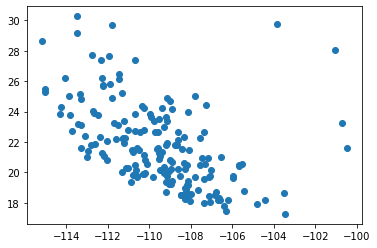

In [17]:
plt.scatter(tc_lons, tc_lats)

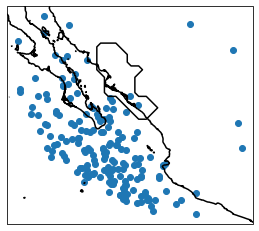

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.scatter(tc_lons, tc_lats, transform=cartopy.crs.PlateCarree())
plt.show()

In [28]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
print(len(tutt_sub))
print(len(tc_lats), len(tc_induced_flag))
print(np.sum(tc_sub-tc_induced_flag))

3048
178 3048
0.0


In [33]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
def add_latlon(ax, top, left, bottom, right):
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top
    gl.left_labels = left
    gl.right_labels = right
    gl.bottom_labels=bottom
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator([0, 20, 25, 30])
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -80])

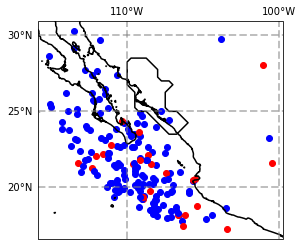

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
tc_ind = 0
index = []
for i in range(3048):
    if tc_induced_flag[i]==1 and tutt_sub[i]==1:
        ax.scatter(tc_lons[tc_ind], tc_lats[tc_ind], transform=cartopy.crs.PlateCarree(), color='red')
        tc_ind+=1
        index.append(i)
    if tc_induced_flag[i]==1 and tutt_sub[i]!=1:
        ax.scatter(tc_lons[tc_ind], tc_lats[tc_ind], transform=cartopy.crs.PlateCarree(), color='blue')
        tc_ind+=1
add_latlon(ax, top=True, left=True, bottom=False, right=False)
plt.show()

In [36]:
print(index)

[173, 368, 457, 622, 623, 679, 1147, 1213, 1361, 1488, 1670, 1870, 1871, 1872, 1873, 2066, 2229, 2256, 2287, 2587, 2719, 2720, 2733, 3002]


In [38]:
pv200 = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/1979-2018_pv200_all.nc')
pv200 = pv200.resample(time='1D').first()

In [39]:
precip_days[7]

array(['1979-06-02T00:00:00.000000000', '1979-06-03T00:00:00.000000000',
       '1979-06-04T00:00:00.000000000', ...,
       '2018-09-28T00:00:00.000000000', '2018-09-29T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

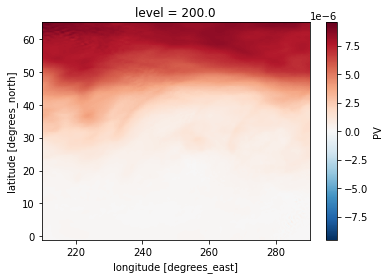

In [41]:
tc_utt_days = np.take(precip_days[7], index)
pv200_sel = pv200.sel(time=tc_utt_days).mean(dim='time')
pv200_sel.plot()

In [43]:
precip_days[7][index[0]]

numpy.datetime64('1981-07-09T00:00:00.000000000')

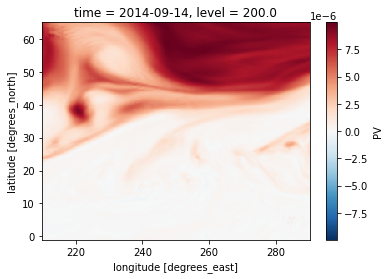

In [50]:
pv200_sel = pv200.sel(time=precip_days[7][index[20]])
pv200_sel.plot()

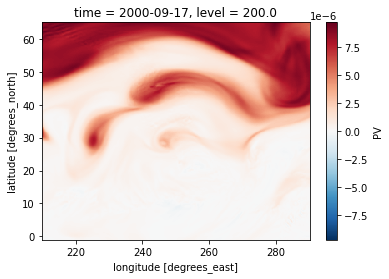

In [49]:
pv200_sel = pv200.sel(time=precip_days[7][index[10]])
pv200_sel.plot()

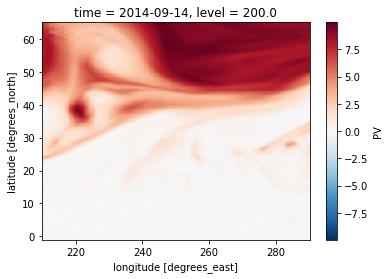

In [53]:
pv200_sel = pv200.sel(time=precip_days[7][index[20]])
pv200_sel = pv200_sel*(10**6)
pv200_sel.plot()

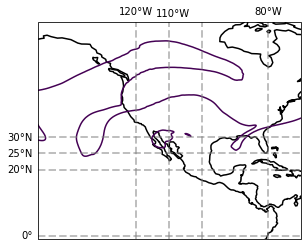

In [54]:
pv200_sel = pv200.sel(time=precip_days[7][index[10]])
pv200_sel = pv200_sel*(10**6)
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax.contour(pv200_sel.longitude, pv200_sel.latitude, pv200_sel, levels=[2])